In [1]:
cd ..

c:\Users\auror\New_VAES


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from src.encoders_decoders import *
from src.losses import *
from torch.utils.data import DataLoader
import itertools
import random
from src.useful_functions import *

In [3]:
#Architecture parameters and distributions of stimuli
N = 10
K = 10
p_x = torch.distributions.uniform.Uniform(0,15)

#Training parameters
N_EPOCHS = 5000
N_SAMPLES = 500
lr = 1e-2
BATCH_SIZE = 500

#Generate samples
x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
x_fine = torch.linspace(x_min,x_max,1000)[:,None]

In [4]:
#Initialization of encoder and decoder 
enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted)
dec = MLPDecoder(N,200)
r = enc.sample(x_fine,100)
r_all = np.asarray(list(itertools.product([0, 1], repeat=N)))
r_all = torch.tensor(r_all).transpose(0,1).type(torch.float)
enc(x_sorted)

tensor([[ -0.1744, -10.9917, -28.1760,  ...,  -3.1315,  -1.2332, -21.0174],
        [ -0.1675, -10.9364, -28.0874,  ...,  -3.1020,  -1.2148, -20.9409],
        [ -0.1324, -10.6378, -27.6076,  ...,  -2.9440,  -1.1166, -20.5269],
        ...,
        [-41.1658, -12.3789,  -2.3275,  ..., -25.6453, -32.7552,  -5.0591],
        [-41.4825, -12.5527,  -2.4033,  ..., -25.8953, -33.0377,  -5.1705],
        [-41.8525, -12.7567,  -2.4930,  ..., -26.1878, -33.3681,  -5.3017]],
       grad_fn=<AddBackward0>)

Text(0, 0.5, 'Encoding')

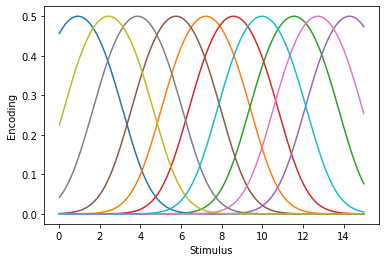

In [5]:
#Initialized encoder before training
plt.plot(x_fine,torch.sigmoid(enc(x_fine)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")

In [6]:
q = rate_ising(N)
q.r_all
q.h


Parameter containing:
tensor([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]],
       requires_grad=True)

In [7]:
loss = q(enc,x_fine)
dist = distortion_gaussian(x_fine,enc,dec)


In [10]:
q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
params = itertools.chain(enc.parameters(),q.parameters(), dec.parameters())
lr = 1e-3
opt = torch.optim.Adam(params,lr)
lVec = []
for n in range(10000):
    rate = q(enc,x_fine)
    dist = distortion_gaussian(x_fine,enc,dec)
    loss = rate + dist
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    lVec.append(loss.item())

In [16]:
enc(x_sorted)
q.J

Parameter containing:
tensor([[ 0.0000, -2.1565, -2.0936, -1.9597, -2.2386, -2.1614, -2.2088, -2.3233,
         -0.0589, -2.0113],
        [-2.1565,  0.0000, -1.8607, -0.2200, -1.7681, -0.2364, -1.8560, -1.9571,
         -1.8466, -1.7744],
        [-2.0936, -1.8607,  0.0000, -2.0054, -2.2298, -1.9218, -0.0436, -1.8536,
         -1.9955, -0.1326],
        [-1.9597, -0.2200, -2.0054,  0.0000, -1.9241, -2.0088, -1.8063, -1.8634,
         -2.0135, -0.2331],
        [-2.2386, -1.7681, -2.2298, -1.9241,  0.0000, -2.0842, -0.0150, -2.1858,
         -2.1642, -1.8119],
        [-2.1614, -0.2364, -1.9218, -2.0088, -2.0842,  0.0000, -1.8755, -0.1844,
         -2.2335, -1.8943],
        [-2.2088, -1.8560, -0.0436, -1.8063, -0.0150, -1.8755,  0.0000, -2.1131,
         -2.0760, -1.9704],
        [-2.3233, -1.9571, -1.8536, -1.8634, -2.1858, -0.1844, -2.1131,  0.0000,
         -0.1418, -1.9575],
        [-0.0589, -1.8466, -1.9955, -2.0135, -2.1642, -2.2335, -2.0760, -0.1418,
          0.0000, -2.0582

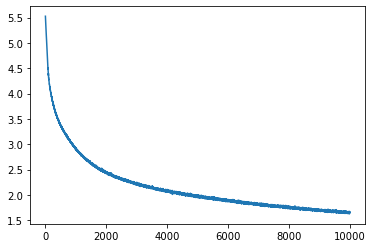

In [12]:
plt.plot(lVec)

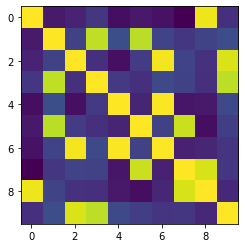

In [13]:
plt.imshow(q.J.detach(),vmin=q.J.min().item(),vmax=q.J.max().item())


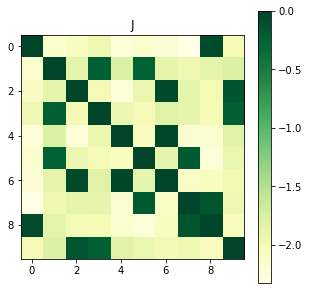

In [14]:
a = (q.J).detach()
show_plots([a])

Text(0, 0.5, 'Encoding')

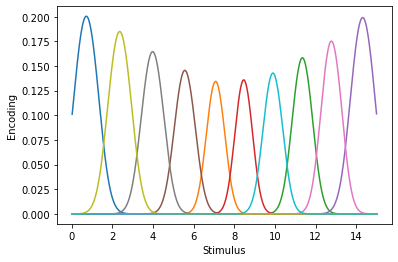

In [15]:
plt.plot(x_fine,torch.sigmoid(enc(x_fine)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")

In [74]:
np.save('myspikes.npy',rTA.numpy())

In [34]:
r= enc.sample(x_fine,10)
r.mean(dim=1).sum()

torch.Size([1000, 10])

In [8]:
r_all.shape

(1024, 10)